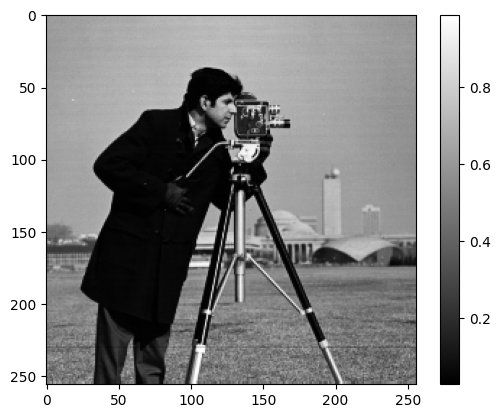

In [2]:
# 1(a)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request
from PIL import Image
import time
from scipy.ndimage import gaussian_filter
import scipy.sparse.linalg as splinalg
from scipy.sparse import spdiags
from scipy import sparse
from scipy.optimize import root,brentq
from scipy.sparse.linalg import spsolve


# Read the image from the URL
url = 'http://www.cs.ucl.ac.uk/staff/S.Arridge/teaching/optimisation/CW2/Cameraman256.png'

with urllib.request.urlopen(url) as url_response:
    with Image.open(url_response) as img:
        im = np.array(img)

# Convert to float and normalize to [0, 1] range
im = np.float32(im)/255.0

# Display the image with a gray colormap and colorbar
imgplot = plt.imshow(im, cmap='gray')
plt.colorbar()
plt.show()


In [4]:
# 1(b)

def apply_convolution(f, sigma, theta):
    # Apply Gaussian filter
    gf = gaussian_filter(f, sigma)
    
    # Add noise to blurred image
    w, h = gf.shape
    noise = np.random.randn(w, h)
    gf = gf + theta * noise
    
    return gf  


In [5]:
# 1(c)

def ATA_operator(f, sigma, alpha):
    # Apply A^T A + alpha*I operator to f
    Af = gaussian_filter(f, sigma) 
    ATAf = gaussian_filter(Af, sigma)
    return ATAf + alpha * f

# def ATA(f, sigma, alpha):
#     # Compute A.TA(f) using Gaussian convolution
#     Af = gaussian_filter(f, sigma)
#     Af = Af.reshape(-1, 1)
#     ATAf = gaussian_filter(Af.reshape(f.shape), sigma)
#     ATAf = (ATAf + alpha * f).reshape(-1)
#     return ATAf

def deconvolve_normal_equations(g, sigma, alpha):
    # Set up linear operator for ATA
    M, N = g.shape
    A = sparse.linalg.LinearOperator((M*N, M*N), matvec=lambda x: np.ravel(ATA_operator(x.reshape(g.shape), sigma, alpha)))

    # Compute ATg
    # ATg = gaussian_filter(g, sigma).flatten()
    ATg = np.ravel(gaussian_filter(g, sigma))

    # Solve linear system using GMRES
    f_alpha, info = splinalg.gmres(A, ATg)

    return f_alpha.reshape((M, N))

def normal_info(g, sigma, alpha):
    # Set up linear operator for ATA
    M, N = g.shape
    A = sparse.linalg.LinearOperator((M*N, M*N), matvec=lambda x: np.ravel(ATA_operator(x.reshape(g.shape), sigma, alpha)))

    # Compute ATg
    # ATg = gaussian_filter(g, sigma).flatten()
    ATg = np.ravel(g)

    # Solve linear system using GMRES
    f_alpha, info = splinalg.gmres(A, ATg)

    return info

# def deconvolve_normal_equations(g, sigma, alpha, maxiter=100, tol=1e-6):
#     # Define linear operator for ATA
#     ATA_op = lambda x: ATA(x.reshape(g.shape), sigma, alpha)

#     # Vectorize g for use in GMRES
#     g_vec = g.reshape(-1)

#     # Solve normal equations using GMRES
#     A = sparse.linalg.LinearOperator((g_vec.size, g_vec.size), matvec=ATA_op, dtype=g.dtype)
#     f_vec, info = sparse.linalg.gmres(A, g_vec, tol=tol, maxiter=maxiter)
#     f = f_vec.reshape(g.shape)

#     return f

In [6]:
# 1(d)
# def M_f(f):
#     # Implementation of the augmented matrix multiplication
#     Af = gaussian_filter(f, sigma)
#     Af = Af.flatten().reshape((-1, 1))
#     zeros = np.zeros((f.size, 1))
#     zeros = zeros.reshape((-1, 1))
#     Mf = np.vstack((Af, np.sqrt(alpha) * zeros))
#     return Mf.flatten()

def M_f(f):
    # Implementation of the augmented matrix multiplication
    y = gaussian_filter(f, sigma)
    z = gaussian_filter(y, sigma)
    M_f = np.vstack([np.ravel(z), np.sqrt(alpha)*np.ravel(f)])
    return M_f

# def MT_b(b):
#     # Implementation of the transposed augmented matrix multiplication
#     M, N = g.shape
#     f = b[:M*N].reshape((M, N))
#     ATg = gaussian_filter(f, sigma, mode='constant', cval=0)
#     ATg = gaussian_filter(ATg, sigma, mode='constant', cval=0)
#     zeros = np.zeros((M, N))
#     MTb = np.hstack((ATg.flatten().reshape((-1, 1)), np.sqrt(alpha) * zeros.flatten().reshape((-1, 1))))
#     return MTb.flatten()

def MT_b(b):
    # Implementation of the transposed augmented matrix multiplication
    global sigma, theta, im, alpha
    g = apply_convolution(im, sigma, theta)
    M, N = g.shape
    g_vec = b[:M*N]
    f_vec = b[M*N:]
    g = np.reshape(g_vec, (M, N))
    y = gaussian_filter(g, sigma)
    z = gaussian_filter(y, sigma)
    MT_b = np.ravel(z) + np.sqrt(alpha)*np.ravel(f_vec)
    return MT_b

def solve_augmented_equations(g):
    # Define linear operator for lsqr
    M, N = g.shape
    size = M*N
    A = sparse.linalg.LinearOperator((2*size, size), matvec=M_f, rmatvec=MT_b)

    # Concatenate g with a zero vector
    b = np.vstack([np.reshape(g,(size,1)), np.zeros((size, 1))])
    
    # Solve linear system using lsqr
    f_lsqr= splinalg.lsqr(A, b)[0]

    return f_lsqr[:g.size].reshape(g.shape)

def augmented_info(g):
    # Define linear operator for lsqr
    M, N = g.shape
    size = M*N
    A = sparse.linalg.LinearOperator((2*size, size), matvec=M_f, rmatvec=MT_b)

    # Concatenate g with a zero vector
    b = np.vstack([np.reshape(g,(size,1)), np.zeros((size, 1))])
    
    # Solve linear system using lsqr
    info = splinalg.lsqr(A, b)[1]

    return info

Method c: Converged in 0 iterations (0.10271835327148438 seconds)
Method d: Converged in 2 iterations (0.09243392944335938 seconds)


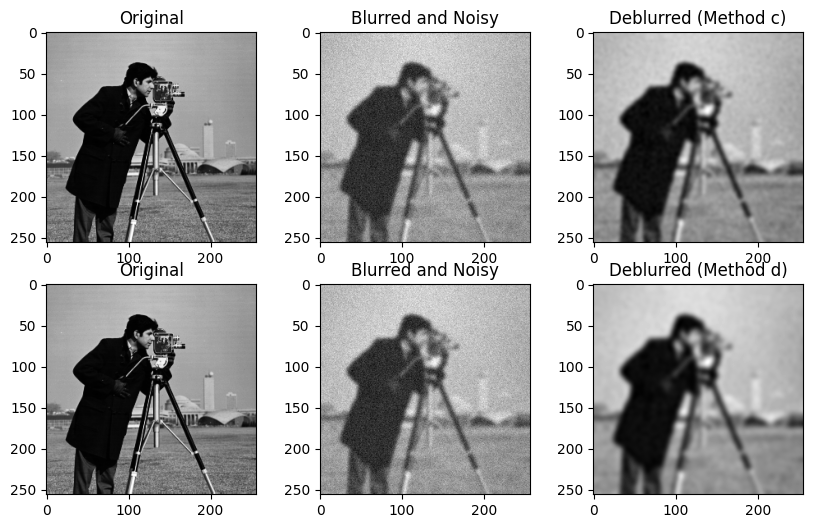

In [7]:
# 1e)


sigma = 2.0
theta = 0.05


def convolve_and_add_noise(alpha):
    global sigma, theta, im
    g = apply_convolution(im, sigma, theta)
    # Deconvolve using normal equations (method c)
    tc1 = time.time()
    f_alpha = deconvolve_normal_equations(g, sigma, alpha);
    tc2 = time.time()
    info = normal_info(g, sigma, alpha) 
    print('Method c: Converged in {} iterations ({} seconds)'.format(info, tc2-tc1))

    # Deconvolve using augmented equations (method d)
    alpha = 0.01
    td1 = time.time()
    f_aug = solve_augmented_equations(g);
    td2 = time.time()
    info = augmented_info(g)
    print('Method d: Converged in {} iterations ({} seconds)'.format(info, td2-td1))

    # Display results
    fig, ax = plt.subplots(2, 3, figsize=(10, 6))
    ax[0,0].imshow(im, cmap='gray')
    ax[0,0].set_title('Original')
    ax[0,1].imshow(g, cmap='gray')
    ax[0,1].set_title('Blurred and Noisy')
    ax[0,2].imshow(f_alpha, cmap='gray')
    ax[0,2].set_title('Deblurred (Method c)')

    ax[1,0].imshow(im, cmap='gray')
    ax[1,0].set_title('Original')
    ax[1,1].imshow(g, cmap='gray')
    ax[1,1].set_title('Blurred and Noisy')
    ax[1,2].imshow(f_aug, cmap='gray')
    ax[1,2].set_title('Deblurred (Method d)')
    plt.show()

alpha = 1
convolve_and_add_noise(alpha)


In [8]:
# 2a


# method c

def discrepancy_function_nor(alpha, g, sigma):
    # Compute the residual
    f_alpha = deconvolve_normal_equations(g, sigma, alpha)
    r_alpha = apply_convolution(f_alpha, sigma, 0) - g
    
    r_norm = np.linalg.norm(r_alpha)

    # Compute the discrepancy principle
    n = g.size
    sigma_sq = (r_norm / np.sqrt(n))**2
    dp = 1/n * r_norm**2 - sigma_sq
    
    return dp

def find_optimal_alpha_dp_nor(g, sigma):
    # Set up alpha range
    alpha_min = 1e-5
    # alpha_max = 1
    
    # Find the value of alpha that gives the zero of the DP(alpha) function
    try:
        # alpha_dp = brentq(discrepancy_function_nor, alpha_min, alpha_max, args=(g, sigma))
        alpha_dp = root(discrepancy_function_nor, alpha_min, args=(g, sigma)).x[0]

        print("Optimal alpha value using Discrepancy Principle for deconvolution using normal equations: ", alpha_dp)
    except ValueError:
        print("Failed to find optimal alpha using Discrepancy Principle.")
    return alpha_dp

g = apply_convolution(im, sigma, theta)

alpha_dp_c = find_optimal_alpha_dp_nor(g,sigma)


# method d

def discrepancy_function_aug(alpha, g, sigma):
    # Compute the residual
    f_alpha = solve_augmented_equations(g)
    r_alpha = apply_convolution(f_alpha, sigma, 0) - g
    r_norm = np.linalg.norm(r_alpha)

    # Compute the discrepancy principle
    n = g.size
    sigma_sq = (r_norm / np.sqrt(n))**2
    dp = 1/n * r_norm**2 - sigma_sq
    
    return dp

def find_optimal_alpha_dp_aug(g, sigma):
    # Set up alpha range
    alpha_min = 1e-2
    # alpha_max = 1
    
    # Find the value of alpha that gives the zero of the DP(alpha) function
    try:
        # alpha_dp = brentq(discrepancy_function_aug, alpha_min, alpha_max, args=(g, sigma))
        alpha_dp = root(discrepancy_function_aug, alpha_min, args=(g, sigma)).x[0]
        print("Optimal alpha value using Discrepancy Principle for deconvolution using augmented equations: ", alpha_dp)
    except ValueError:
        print("Failed to find optimal alpha using Discrepancy Principle.")
    return alpha_dp
    
alpha_dp_d = find_optimal_alpha_dp_aug(g,sigma)



Optimal alpha value using Discrepancy Principle for deconvolution using normal equations:  1e-05
Optimal alpha value using Discrepancy Principle for deconvolution using augmented equations:  0.01


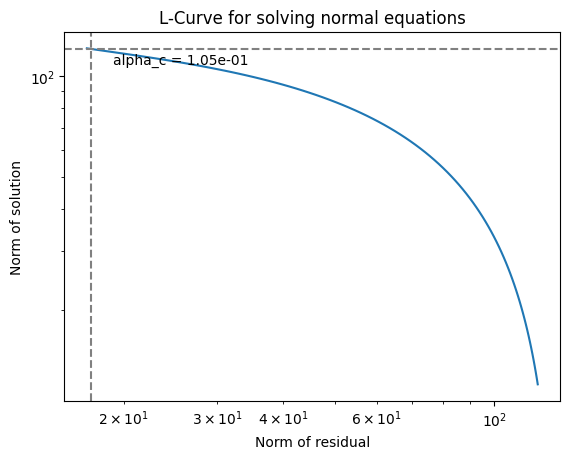

In [9]:
# 2b

# Define range of alpha values to test
alphas = np.logspace(-1, 1, num=100)

# method c
def l_curve(g, sigma, alphas, deconvolve_fun):
    norm_f = []
    norm_residual = []
    
    
    for alpha in alphas:
        if deconvolve_fun == 'normal equations':
            # Compute f for current alpha
            f_alpha = deconvolve_normal_equations(g, sigma, alpha)
        elif deconvolve_fun == 'augmented equations':
            print('L-curve is not applicable to augmented equations method')
        # Compute residual and f norms
        r_alpha = g - f_alpha #gaussian_filter(f_alpha, sigma)
        norm_f.append(np.linalg.norm(f_alpha))
        norm_residual.append(np.linalg.norm(r_alpha))
        

    return norm_f, norm_residual

# Compute the L-curve
norm_f_nor, norm_residual_nor = l_curve(g, sigma, alphas, 'normal equations')


def plot_l_curve(norm_f, norm_residual, deconvolve_fun):
    assert deconvolve_fun == 'normal equations', 'L-curve is not applicable to augmented equations method'
    # Plot the L-curve
    plt.loglog(norm_residual, norm_f)
    plt.xlabel('Norm of residual')
    plt.ylabel('Norm of solution')
    plt.title('L-Curve for solving {}'.format(deconvolve_fun))

    # Find the optimal alpha value based on the L-curve
    curvature = []
    for i in range(1, len(alphas)-1):
        dx1 = norm_residual[i] - norm_residual[i-1]
        dy1 = norm_f[i] - norm_f[i-1]
        dx2 = norm_residual[i+1] - norm_residual[i]
        dy2 = norm_f[i+1] - norm_f[i]
        curvature.append(abs(dx1*dy2 - dx2*dy1) / ((dx1**2 + dy1**2)**1.5 * (dx2**2 + dy2**2)**1.5))

    optimal_index = np.argmax(curvature) + 1
    alpha_l = alphas[optimal_index]

    # Plot the optimal alpha value
    plt.axvline(norm_residual[optimal_index], linestyle='--', color='gray')
    plt.axhline(norm_f[optimal_index], linestyle='--', color='gray')
    plt.text(norm_residual[optimal_index]*1.1, norm_f[optimal_index]*0.9, 'alpha_c = {:.2e}'.format(alpha_l))

    plt.show()
    return alpha_l

alpha_l_c = plot_l_curve(norm_f_nor, norm_residual_nor, 'normal equations')

Method c: Converged in 0 iterations (14.788245916366577 seconds)
Method d: Converged in 2 iterations (0.0833895206451416 seconds)


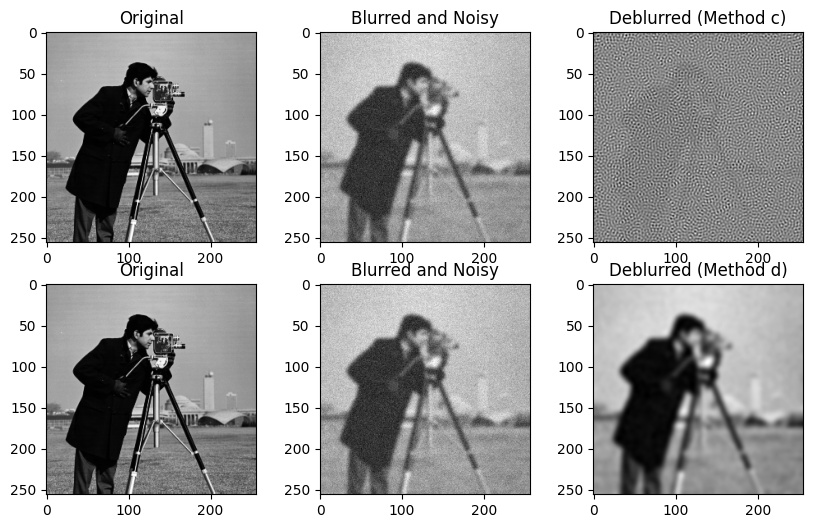

In [11]:
# 2(c) results using these two optimal alphas.
# DP method c
convolve_and_add_noise(alpha_dp_c)

Method c: Converged in 0 iterations (0.27139997482299805 seconds)
Method d: Converged in 2 iterations (0.04271340370178223 seconds)


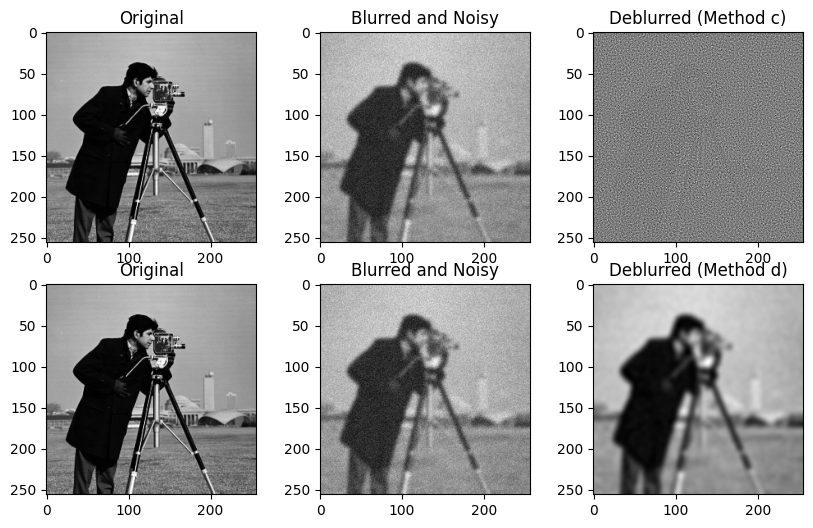

In [ ]:
# DP method d
convolve_and_add_noise(alpha_dp_d)

Method c: Converged in 0 iterations (0.08066129684448242 seconds)
Method d: Converged in 2 iterations (0.08366680145263672 seconds)


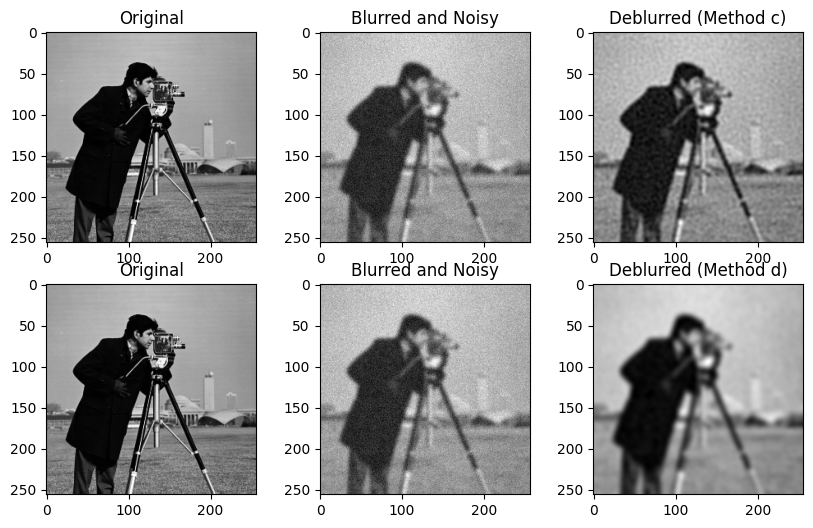

In [12]:
# l-curve method c
convolve_and_add_noise(alpha_l_c)

In [6]:
# 3a)
def gradient_operator(im, is_transpose=False):
    if not is_transpose:
        # Forward difference operator
        grad_x = np.diff(im, axis=1)
        grad_y = np.diff(im, axis=0)
        # Pad the end of each dimension with zeros to maintain shape
        grad_x = np.pad(grad_x, ((0, 0), (0, 1)), mode='constant')
        grad_y = np.pad(grad_y, ((0, 1), (0, 0)), mode='constant')
        # Stack x and y gradients to make a (M*N, 2) matrix
        grad = np.column_stack([grad_x.ravel(), grad_y.ravel()])
        return grad
    else:
        # Transpose of forward difference operator
        shape = im.shape
        # Reshape input to a (M*N, 2) array
        # Compute the transpose operator by taking backward differences
        DT_im = np.zeros((*shape,2), dtype=np.float64)
        DT_im[:, :-1,  0] -= im[:, :-1] - im[:, 1:]
        DT_im[:, 1:,  0] += im[:, :-1] - im[:, 1:]
        DT_im[:-1, :, 1] -= im[:-1, :] - im[1:, :]
        DT_im[1:, :, 1] += im[:-1, :] - im[1:, :]
        DT_im = DT_im.squeeze() # remove extra dimension from DT_im
        return DT_im.reshape(*shape,2)


# Create random arrays u and v
shape = im.shape
u = np.random.rand(*shape)
v = np.random.rand(*shape)
u_flat = u.reshape(-1, 1)  # Shape is (65536, 1)
v_flat = v.reshape(-1, 1)  # Shape is (65536, 1)

# Compute < Du, v > and < u, DTv >
Du = gradient_operator(u)
DTv = gradient_operator(v,is_transpose = True)

DTv_flat = DTv.reshape(-1, 2)  # Shape is (65536, 2)
u_flat_broadcast = np.broadcast_to(u_flat, (65536, 2))  # Shape is (65536, 2)

Du_flat = Du.reshape(-1, 2)  # Shape is (65536, 2)
v_flat_broadcast = np.broadcast_to(v_flat, (65536, 2))  # Shape is (65536, 2)


left = np.dot(Du_flat, v_flat_broadcast.T).sum()
right = np.dot(u_flat_broadcast, DTv_flat.T).sum()

# Check if the two sides are equal
tol = 1e-8
if np.abs(left - right) < tol:
    print("Identity verified!")
else:
    print("Error: left and right sides are not equal.")


In [ ]:
# 3b)
def ATA_operator(f, sigma, alpha):
    # Apply A^T A + alpha*I operator to f
    Af = filters.gaussian_filter(f, sigma) 
    ATAf = filters.gaussian_filter(Af, sigma)
    grad = gradient_operator(f)
    grad_reg = alpha * np.eye(grad.shape[0])
    return ATAf + grad.T @ grad + grad_reg


def deconvolve_normal_equations(g, sigma, alpha):
    # Set up linear operator for ATA
    M, N = g.shape
    I = sparse.eye(M*N)
    ATA = sparse.linalg.LinearOperator((M*N, M*N), matvec=lambda x: np.ravel(ATA_operator(x.reshape(g.shape), sigma, alpha)))
    A = I + alpha * ATA
    # Compute ATg
    ATg = np.ravel(g)
    # Solve linear system
    f_alpha = sparse.linalg.spsolve(A, ATg)
    # Reshape solution
    f_alpha = f_alpha.reshape(g.shape)

    return f_alpha

def solve_augmented_equations(g, sigma, alpha):
    # Define linear operator for lsqr
    M, N = g.shape
    size = M*N
    A = sparse.linalg.LinearOperator((2*size, size), matvec=M_f, rmatvec=MT_b)
    A_aug = sparse.bmat([[ATA_operator(np.eye(size), sigma, alpha)], [A]])

    # Concatenate g with a zero vector
    b = np.vstack([np.reshape(g,(size,1)), np.zeros((size, 1))])
    b_aug = np.vstack([np.zeros((size, 1)), b])

    # Solve linear system using lsqr
    f_lsqr_aug = splinalg.lsqr(A_aug, b_aug)[0]

    return f_lsqr_aug[size:].reshape(g.shape)

def ATA_operator(f, sigma, alpha):
    # Apply Gaussian blur
    Af = gaussian_filter(f, sigma)
    ATAf = np.ravel(gaussian_filter(Af, sigma))

    # Compute regularization term
    grad = gradient_operator(f.shape).astype(np.float64)
    grad_reg = alpha * sparse.eye(grad.shape[0], dtype=np.float64)

    # Compute ATA
    ATA = grad.T @ grad + grad_reg
    ATAf += np.ravel(ATA.dot(np.reshape(f, (-1, 1))))

    return ATAf

def deconvolve_normal_equations(g, sigma, alpha):
    # Set up linear operator for ATA
    M, N = g.shape
    A = sparse.linalg.LinearOperator((M*N, M*N), matvec=lambda x: ATA_operator(x.reshape(g.shape), sigma, alpha))

    # Compute ATg
    ATg = np.ravel(gaussian_filter(g, sigma))

    # Solve normal equations
    f_hat = sparse.linalg.cg(A, ATg)[0].reshape(g.shape)

    return f_hat

def solve_augmented_equations(g, sigma, alpha, beta, max_iter=100, tol=1e-4):
    # Compute ATg
    ATg = gradient_operator(g, is_transpose=True)
    
    # Compute w = Af
    w = gaussian_filter(g, sigma)
    
    # Compute ATw
    ATw = gradient_operator(w, is_transpose=True)
    
    # Set up linear operator for (I + beta*A.T*A)
    M, N = g.shape
    diag = np.ones((2, M*N))
    diag[0] = beta * gradient_operator(np.ones_like(g.ravel()), is_transpose=True)
    diag[1] = 1.0
    A = spdiags(diag, [-M*N, 0], M*N, M*N)
    
    # Compute b = ATg + beta*w
    b = ATg.ravel() + beta * w.ravel()
    
    # Solve the system using the conjugate gradient method
    x, _ = sparse.linalg.cg(A, b, tol=tol, maxiter=max_iter, callback=None)
    
    # Reshape the result to an image
    return x.reshape(g.shape)


In [ ]:
solve_augmented_equations(g, sigma, alpha)

In [ ]:
# 4)


def anisotropic_derivative_filter(g, alpha, T, max_iter=100, eps=1e-5):
    """
    Solve an optimization problem with an anisotropic derivative filter using the Perona-Malik diffusivity function.
    
    Args:
        g (ndarray): the input image
        alpha (float): the regularization strength
        T (float): the threshold for the Perona-Malik function
        max_iter (int): the maximum number of iterations (default: 100)
        eps (float): the stopping criterion (default: 1e-5)
        
    Returns:
        f (ndarray): the denoised image
    """
    # Construct the gradient operator
    Dx = spdiags([-1*np.ones(g.shape[0]), np.ones(g.shape[0])], [0, 1], g.shape[0]-1, g.shape[0])
    Dx = Dx.todense()
    Dx[-1, -1] = -1
    Dx = np.kron(np.eye(g.shape[1]), Dx)
    
    Dy = spdiags([-1*np.ones(g.shape[1]), np.ones(g.shape[1])], [0, 1], g.shape[1]-1, g.shape[1])
    Dy = Dy.todense()
    Dy[-1, -1] = -1
    Dy = np.kron(Dy, np.eye(g.shape[0]))
    
    D = np.vstack((Dx, Dy))
    
    # Initialize gamma
    gradient_norm = np.sqrt(Dx @ g.flatten()**2 + Dy @ g.flatten()**2)
    gamma = np.exp(-gradient_norm / T)
    gamma = spdiags(gamma, 0, len(gradient_norm), len(gradient_norm)).todense()
    
    # Initialize f
    f = g.copy().flatten()
    
    # Run optimization
    for i in range(max_iter):
        f_old = f.copy()
        # Compute gradient and update f
        grad = 2 * (D.T @ (A @ f - g)) + 2 * alpha * (gamma @ D @ f)
        f -= np.linalg.norm(grad) * grad / np.linalg.norm(D @ grad)**2
        # Project f onto [0, 1]
        f[f < 0] = 0
        f[f > 1] = 1
        # Check stopping criterion
        if np.linalg.norm(f - f_old) < eps:
            break
    
    return f.reshape(g.shape)


In [ ]:
#5)
def iterative_deblurring(g, A, alpha, T, max_iter=100, eps=1e-5):
    """
    Perform iterative deblurring with anisotropic derivative filter using the Perona-Malik diffusivity function.
    
    Args:
        g (ndarray): the observed blurry image
        A (ndarray): the blurring operator
        alpha (float): the regularization strength
        T (float): the threshold for the Perona-Malik function
        max_iter (int): the maximum number of iterations (default: 100)
        eps (float): the stopping criterion (default: 1e-5)
        
    Returns:
        f (ndarray): the deblurred image
    """
    # Initialize variables
    f = g.copy()
    
    # Iterate until convergence
    for i in range(max_iter):
        # Compute diffusivity
        gradient_norm = np.sqrt((Dx @ f.flatten())**2 + (Dy @ f.flatten())**2)
        gamma = np.exp(-gradient_norm / T)
        gamma = spdiags(gamma, 0, len(gradient_norm), len(gradient_norm)).todense()
        
        # Compute denoised image
        f_old = f.copy()
        f = spsolve(A.T @ A + alpha * D.T @ gamma @ D, A.T @ g.flatten())
        f = f.reshape(g.shape)
        
        # Check convergence
        if np.linalg.norm(f - f_old) < eps:
            print("Algorithm converged after", i+1, "iterations.")
            break
            
        # Check maximum number of iterations
        if i+1 == max_iter:
            print("Maximum number of iterations reached.")
            
    return f
